## Stochastic Volatility Model

$$
dX_t = \mu dt + \sqrt{Z_t} dW^x_t \\
dZ_t = (\theta + \kappa Z_t) dt + \sigma_z \sqrt{Z_t} dW_t^z
$$

In this example the volatility of the volatility, $\sigma_z$, is held constant as it is challenging to estimate

Priors: 

$$
\theta \sim TruncNorm()  \\
\kappa \sim TruncNorm()
$$

In [1]:
import jax
import jax.numpy as jnp
import jax.scipy as jsp
import jax.random as random
from jax import lax
import pandas as pd
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt

# plotting
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import pfjax as pf
import pfjax.sde as sde

from functools import partial

from pfjax import particle_resamplers as resampler

import time
from tqdm import tqdm

import warnings
warnings.filterwarnings("ignore")

In [2]:
from pfjax.models.base_model import BaseModel
from pfjax import sde
import pfjax.mcmc as mcmc

In [3]:
def euler_sim_nojump(key, x, dt, drift_diff, theta):
    """
    Simulate SDE with dense diffusion using Euler-Maruyama discretization.
    Args:
        key: PRNG key.
        x: Initial value of the SDE.  A vector of size `n_dims`.
        dt: Interobservation time.
        drift: Drift function having signature `drift(x, theta)` and returning a vector of size `n_dims`.
        diff: Diffusion function having signature `diff(x, theta)` and returning a vector of size `n_dims`.
        theta: Parameter value.
    Returns:
        Simulated SDE values. A vector of size `n_dims`.
    """
    _, diff_subkey, jump_subkey = random.split(key, 3)
    diff_process = drift_diff(diff_subkey, x, theta, dt)
#     jump_process = jump(jump_subkey, x, theta, dt)
    return diff_process #jnp.append(diff_process + jump_process, jump_process)

class SDEModel(object):
    def __init__(self, dt, n_res):
        self._dt = dt
        self._n_res = n_res
        
        def euler_sim(self, key, x, dt, theta):
            return euler_sim_nojump(key, x, dt, self.drift_diff, theta)
        
        setattr(self.__class__, 'euler_sim', euler_sim)
    
    def state_sample(self, key, x_prev, theta):
        def fun(carry, t):
            key, subkey = random.split(carry["key"])
            x = self.euler_sim(
                key=subkey, x=carry["x"],
                dt=self._dt/self._n_res, theta=theta
            )
            res = {"x": x, "key": key}
            return res, x
        init = {"x": x_prev[-1], "key": key}
        last, full = lax.scan(fun, init, jnp.arange(self._n_res))
        return full
    
    def is_valid_state(self, x, theta):
        return not jnp.sum(x < 0) > 0
    
    def meas_lpdf(self, y_curr, x_curr, theta):
        return 1.0

In [40]:
class StochVol(SDEModel):
    
    def __init__(self, dt, n_res, sigma_z):
        """ remove sigma_z from the model because it is apparently hard to estimate (form Golightly) """
        super().__init__(dt, n_res)
        self._n_state = (self._n_res, 2)
        self._sigma_z = sigma_z
    
    def _unpack(self, theta):
        return theta[0], theta[1], theta[2] #, theta[3]
#         return theta[0], theta[1], self._sigma_z, theta[3]
        
    def _validator(self, x):
        """ make sure vol and price never go negative """
        return jnp.abs(x)
    
    def drift(self, x, theta):
#         _theta, kappa, sigma_z, mu = self._unpack(theta)
        x = self._validator(x)
        _theta, kappa, mu = self._unpack(theta)
        mu = jnp.array([_theta + kappa*x[0], mu])
        return mu
    
    def diff(self, x, theta):
        x = self._validator(x)
        _theta, kappa, mu = self._unpack(theta)
        Sigma = jnp.array([[x[0]*(sigma_z**2), 0],
                           [0, x[0]]])
        return Sigma
    
    def drift_diff(self, key, x, theta, dt):
        mu = self.drift(x, theta)
        Sigma = self.diff(x, theta)
        diff_process = jax.random.multivariate_normal(key, mean = x+mu*dt, cov=Sigma*dt)
        diff_process = diff_process.at[0].set(jnp.abs(diff_process[0]))
        return diff_process
        
    def meas_sample(self, key, x_curr, theta):
        return x_curr[-1][1]
    
    def state_lpdf(self, x_curr, x_prev, theta):
        r"""
        Sample from Euler transition density: `p(x_curr | x_prev, theta)`
        """
        x0 = jnp.concatenate([x_prev[-1][None], x_curr[:-1]])
        x1 = x_curr
        
        def euler_lpdf_jump(x_curr, x_prev, dt, theta):
            return jsp.stats.norm.logpdf(
                x=x_curr[1],
                loc=x_prev[1] + self.drift(x_prev, theta)[1]*dt,
                scale=jnp.sqrt(self.diff(x_prev, theta)[1,1]*dt)
            ) 
        
        lp = jax.vmap(lambda xp, xc:
                      euler_lpdf_jump(
                          x_curr=xc, x_prev=xp,
                          dt=self._dt/self._n_res,
                          theta=theta))(x0, x1)
        return jnp.sum(lp)
    
    def _state_lpdf_for(self, x_curr, x_prev, theta):
        dt_res = self._dt/self._n_res
        x0 = jnp.append(jnp.expand_dims(
            x_prev[self._n_res-1], axis=0), x_curr[:self._n_res-1], axis=0)
        x1 = x_curr
        lp = jnp.array(0.0)
        
        for t in range(self._n_res):
            lp = lp + jnp.sum(jsp.stats.norm.logpdf(
                x=x1[t][1],
                loc=x0[t][1] + self.drift(x0[t], theta)[1]*dt_res,
                scale=jnp.sqrt(self.diff(x0[t], theta)[1,1]*dt_res)
            ))
        return lp
    
    def _bridge_param(self, x, y_curr, theta, n):
        _theta, kappa, mu = self._unpack(theta)
        k = self._n_res - n
        dt_res = self._dt/self._n_res
        x = self._validator(x)
        vol=x[0]
        price=x[1]

        mu_z = vol + (_theta+kappa*vol)*dt_res 
        sig2_z = vol*(sigma_z**2)*dt_res

        mu_x = price + (y_curr - price)/k 
        sig2_x = (k - 1)/k*vol*dt_res

        return mu_z, sig2_z, mu_x, sig2_x
    
    def pf_step(self, key, x_prev, y_curr, theta):
        def scan_fun(carry, t):
            key = carry["key"]
            x = carry["x"]
            
            mu_z, sig2_z, mu_x, sig2_x = self._bridge_param(x, y_curr, theta, t)
            key, z_subkey, x_subkey = random.split(key,3)

            x_prop = jnp.array([jnp.abs(mu_z + jnp.sqrt(sig2_z) * random.normal(z_subkey))+1e-10,
                                jnp.where(t < self._n_res-1, 
                                          mu_x + jnp.sqrt(sig2_x) * random.normal(x_subkey),
                                          y_curr)])

            lp_prop = jnp.where(t < self._n_res-1,
                                jsp.stats.norm.logpdf(x=x_prop[1], loc=mu_x, scale=jnp.sqrt(sig2_x)),
                                0.0)

            res_carry = {
                "x": x_prop,
                "key": key,
                "lp": carry["lp"] + lp_prop
            }
            res_stack = {"x": x_prop, "lp": lp_prop}
            return res_carry, res_stack

        key, subkey = random.split(key)
        scan_init = {
            "x": x_prev[self._n_res-1],
            "key": subkey,
            "lp": jnp.array(0.)
        }
        
        ns = jnp.arange(self._n_res)

        last, full = lax.scan(scan_fun, scan_init, (ns))
        x_prop = full["x"]
        logw_trans = self.state_lpdf(
            x_curr=x_prop,
            x_prev=x_prev, 
            theta=theta
        )

        logw = logw_trans - last["lp"]
        return x_prop, logw
    
    def _pf_step_for(self, key, x_prev, y_curr, theta):
        dt_res = self._dt/self._n_res
        x_curr = []
        x_state = x_prev[self._n_res-1]
        lp = jnp.array(0.0)
        
        key, jump_subkey, z_subkey, x_subkey = random.split(key, 4)
        
        for t in range(self._n_res):
            key, z_subkey, x_subkey = random.split(key,3)
            mu_z, sig2_z, mu_x, sig2_x = self._bridge_param(x_state, y_curr, theta, t)
            
            x_state = jnp.array([jnp.abs(mu_z + jnp.sqrt(sig2_z) * random.normal(z_subkey))+1e-10,
                                 jnp.where(t<self._n_res-1, 
                                           mu_x + jnp.sqrt(sig2_x) * random.normal(x_subkey),
                                           y_curr)])

            lp_prop = jnp.where(t<self._n_res-1,
                           jsp.stats.norm.logpdf(x=x_state[1], loc=mu_x, scale=jnp.sqrt(sig2_x)),
                           0.0)
            
            x_curr.append(x_state)
            lp = lp + lp_prop
        
        x_prop = jnp.array(x_curr)
        
        logw_trans = self._state_lpdf_for(
            x_curr=x_prop,
            x_prev=x_prev, 
            theta=theta
        )
        
        logw = logw_trans - lp
        return x_prop, logw
    
    def pf_init(self, key, y_init, theta):
        key, subkey = random.split(key)
        x_init = y_init + 5*random.normal(
            subkey
        )
        z_init = random.truncated_normal(
            subkey,
            lower=0.5,
            upper=10)
        logw = jnp.sum(jsp.stats.norm.logcdf(y_init))
        return \
            jnp.append(jnp.zeros((self._n_res-1,) + (self._n_state[1], )),
                       jnp.expand_dims(jnp.array([z_init, x_init]), axis = 0), axis=0), \
            logw

In [41]:
key = random.PRNGKey(100)

_dt = 1
_n_res = 5
n_obs = 500

# parameters: 
_theta = 0.02
kappa = -0.03
sigma_z = 0.18
mu = 0.008

# theta = jnp.array([_theta, kappa, sigma_z, mu])
theta = jnp.array([_theta, kappa, mu])
x_init = jnp.block([[jnp.zeros((_n_res-1, 2))],
                    [jnp.array([2.0, 45.0])]])

volmodel = StochVol(_dt, _n_res, sigma_z=sigma_z)
y_meas, x_state = pf.simulate(volmodel, key, n_obs, x_init, theta)

In [42]:
point_plot = pd.DataFrame(jnp.array([
    jnp.arange(y_meas.shape[0]) * _n_res,
    y_meas
]).T, columns = ["Time", "Log Asset Price"])

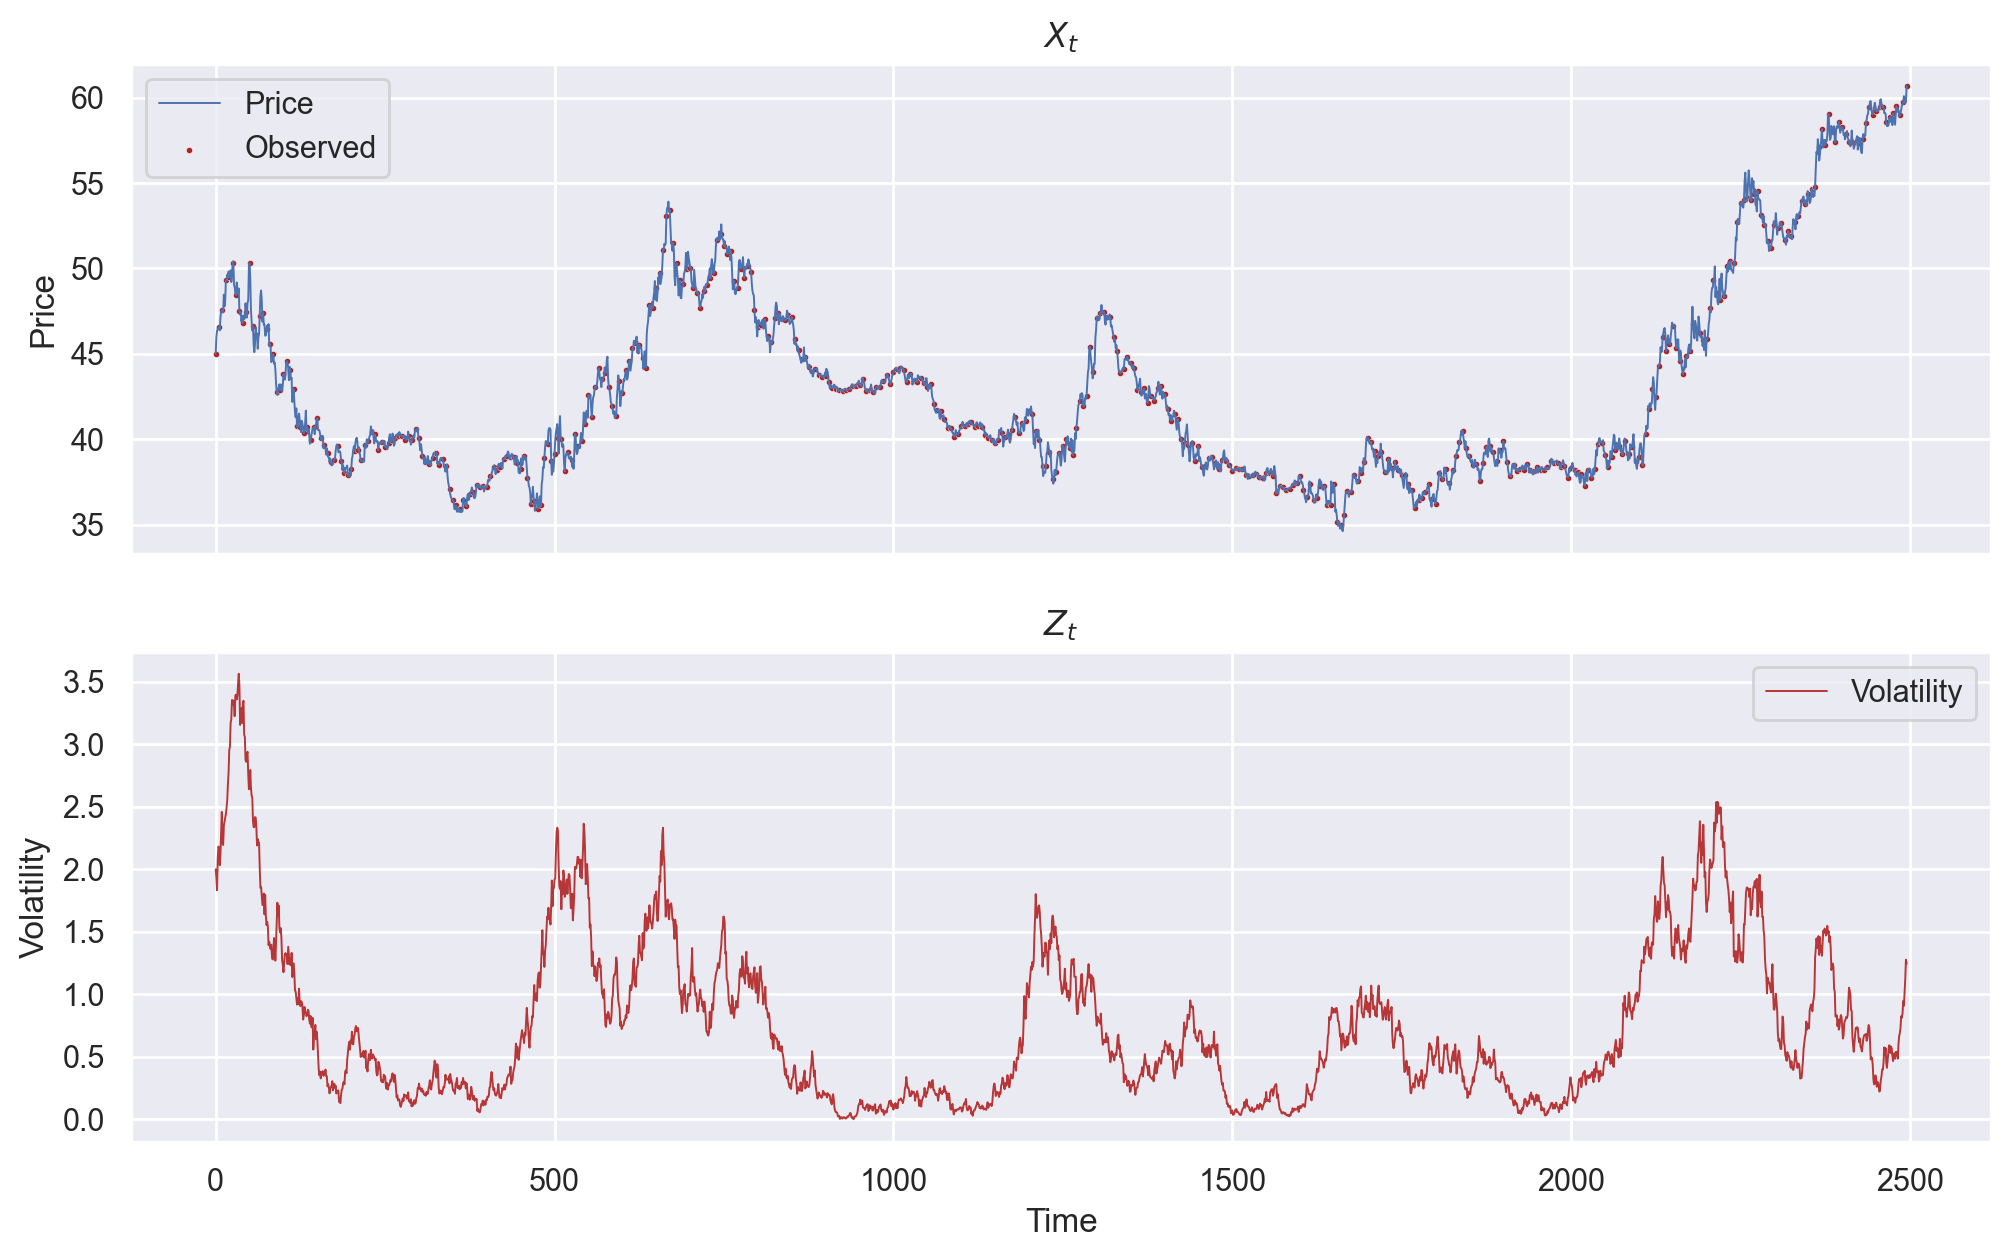

In [43]:
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(12, 7), sharex = True)

sns.lineplot(data= x_state[..., 1].reshape(_n_res*n_obs, 1)[(_n_res-1):].squeeze(),
             ax = ax[0], linewidth=0.7,
             label = "Price").set(title ="$X_t$", ylabel="Price")
sns.scatterplot(x = "Time", y = "Log Asset Price", 
                data = point_plot,
                color = "firebrick",
                ax = ax[0],
                s=5,
                label="Observed").set(title ="$X_t$")

sns.lineplot(data= x_state[..., 0].reshape(_n_res*n_obs,1)[(_n_res-1):].squeeze(),
             ax = ax[1], alpha = 0.9, linewidth=0.7, color = "firebrick",
             label = "Volatility").set(xlabel="Time",title = "$Z_t$", ylabel="Volatility");

In [15]:
num_particles = 1000

pf_jit = jax.jit(partial(
    pf.particle_filter,
    model = volmodel,
    key = random.PRNGKey(0),
    y_meas = y_meas,
    theta = theta, #jnp.array([-90, -3.506558, 0.008]),
    history=True
), static_argnames="n_particles")

multinom_pf = pf_jit(n_particles=num_particles)

In [16]:
def quantile_index (logw, q):
    """
    Returns the index of the q-th quantile of logw
    """
    w = pf.utils.logw_to_prob(logw)
    val = jnp.quantile(w, q=q)
    nearest_ind = jnp.argmin(jnp.abs(val - w)) # find index of closest point to val
    return nearest_ind

est_vol_mean = jax.vmap(
    lambda x, w: jnp.average(x, axis=0, weights=pf.utils.logw_to_prob(w)),
    in_axes = (0, 0))(multinom_pf["x_particles"][1:, ..., 0],
                      multinom_pf["logw"][1:, ...])

est_vol_lower = jax.vmap(
    lambda x, logw: x[quantile_index(logw, q=0.025)],
    in_axes = (0, 0))(multinom_pf["x_particles"][1:, ..., 0],
                      multinom_pf["logw"][1:, ...])

est_vol_upper = jax.vmap(
    lambda x, logw: x[quantile_index(logw, q=0.975)],
    in_axes = (0, 0))(multinom_pf["x_particles"][1:, ..., 0],
                      multinom_pf["logw"][1:, ...])

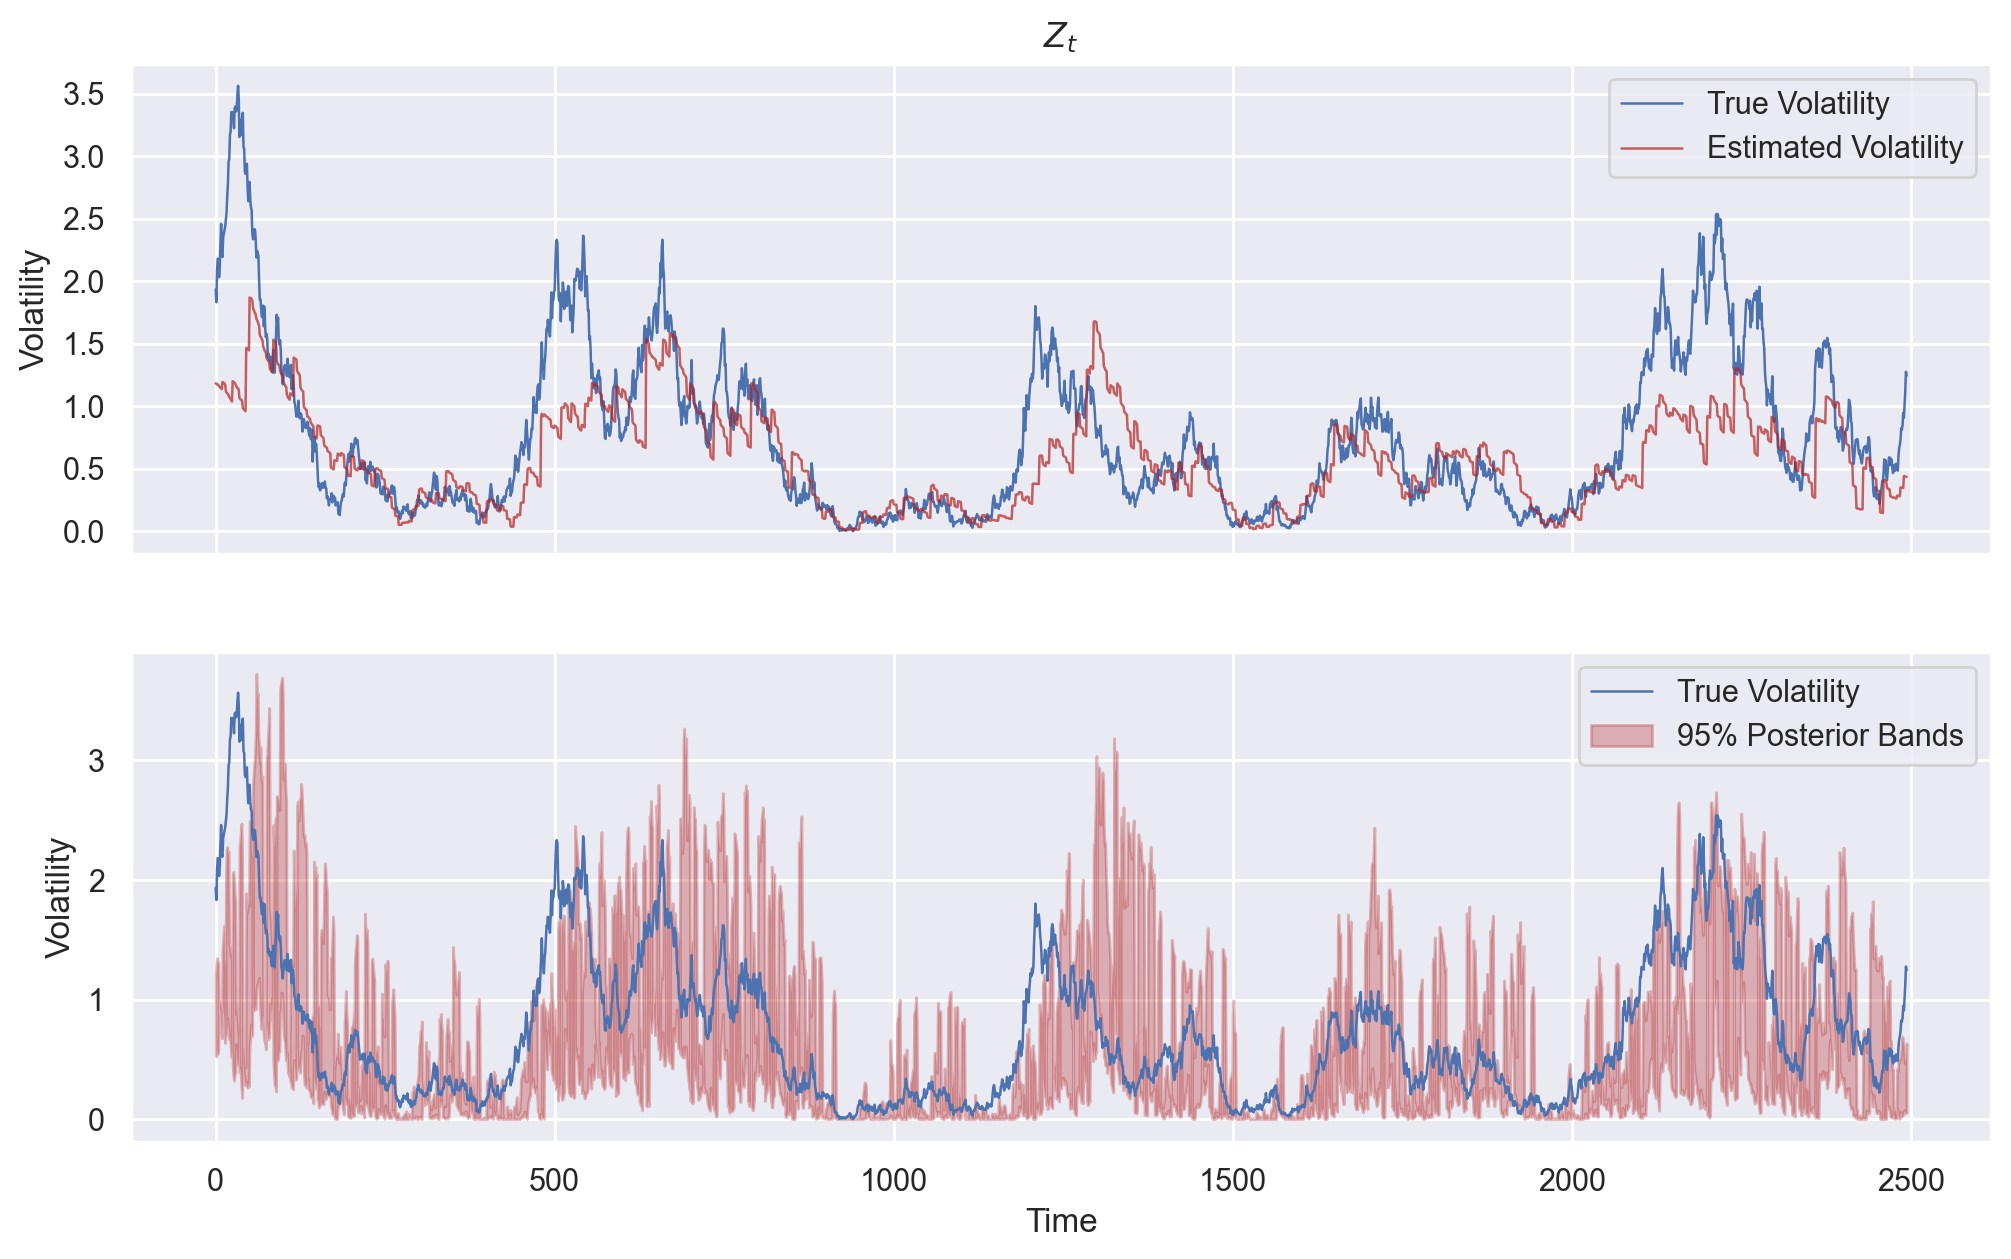

In [17]:
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(12, 7), sharex = True)

sns.lineplot(
    data = x_state[1:, :, 0].flatten(),
    linewidth = 0.9, ax=ax[0],
    label = "True Volatility").set(xlabel="Time",title = "$Z_t$", ylabel="Volatility")
sns.lineplot(data = est_vol_mean.flatten(), 
             color = "firebrick", linewidth = 0.9, 
             alpha = 0.7, ax=ax[0],
             label = "Estimated Volatility")

sns.lineplot(
    data = x_state[1:, :, 0].flatten(), ax=ax[1],
    linewidth=0.9, 
    label = "True Volatility").set(xlabel="Time", ylabel="Volatility")
ax[1].fill_between(
    x = jnp.arange((n_obs-1)*_n_res),
    y1=est_vol_lower.flatten(),
    y2=est_vol_upper.flatten(),
    color = "firebrick",
    label="95% Posterior Bands",
    alpha = 0.3
)
ax[1].legend();

### MWG

In [9]:
def particle_gibbs(key, model, n_iter, theta_init, x_state_init, n_particles, rw_sd,
                   logprior, adapt_max=0.0, adapt_rate=0.1):
    """
    Sample from the joint posterior distribution of parameters and latent states using a Particle Gibbs sampler.

    Args:
        key: PRNG key.
        n_iter: Number of MCMC iterations.
        theta_init: A vector of `n_params` initial parameter values on the unconstrained scale.
        x_state_init: JAX PyTree of initial state variables.
        n_particles: Number of particles for the particle filter.
        rw_sd: Vector of `n_params` initial standard deviations for the adaptive MWG proposal.
        logprior: function accepting theta and returning log(prior density)

    Returns:
        A dictionary with elements

        - **x_state** - MCMC output for the state variables, with leading dimension `n_iter`.
        - **theta** - MCMC output for the unconstrained parameters, with leading dimension `n_iter`.
        - **accept_rate** - Vector of `n_params` acceptance rates.  These should be close to 0.44.
    """
    # initialize the sampler
    n_params = theta_init.size
    amwg = mcmc.AdaptiveMWG(adapt_max=adapt_max, adapt_rate=adapt_rate)
    # initial state of MWG sampler
    initial_state = {
        "theta": theta_init,
        "x_state": x_state_init,
        "adapt_pars": amwg.init(rw_sd),
    }

    def mcmc_update(key, theta, x_state, adapt_pars):
        """
        MCMC update for parameters and latent variables.

        Use Adaptive MWG for the former and a particle filter for the latter.
        """
        keys = jax.random.split(key, num=3) # two for particle_filter, one for amwg
        # latent variable update
        pf_out = pf.particle_filter(
            model=model,
            key=keys[0],
            y_meas=y_meas,
            theta=theta,
            n_particles=n_particles,
            history=True
        )
        x_state = pf.particle_smooth(
            key=keys[1],
            logw=pf_out["logw"][y_meas.shape[0]-1],
            x_particles=pf_out["x_particles"],
            ancestors=pf_out["resample_out"]["ancestors"]
        )

        # parameter update
        @jax.jit
        def logpost(theta):
            """
            Log-posterior of the conditional parameter distribution.
            """
            log_prior = logprior(theta)
            return pf.loglik_full(
                model=model,
                theta=theta,
                x_state=x_state,
                y_meas=y_meas
            ) + log_prior
        
        theta_state, accept = amwg.step(
            key=keys[2],
            position=theta,
            logprob_fn=logpost,
            rw_sd=adapt_pars["rw_sd"]
        )
        # adapt random walk jump sizes
        adapt_pars = amwg.adapt(pars=adapt_pars, accept=accept)
        return theta_state, x_state, adapt_pars, accept

    @jax.jit
    def step(state, key):
        """
        One step of MCMC update.
        """
        theta, x_state, adapt_pars, accept = mcmc_update(
            key=key,
            theta=state["theta"],
            x_state=state["x_state"],
            adapt_pars=state["adapt_pars"]
        )
        new_state = {
            "theta": theta, 
            "x_state": x_state, 
            "adapt_pars": adapt_pars
        }
        stack_state = {
            "theta": theta, 
            "x_state": x_state,
            "adapt_pars": adapt_pars
        }
        return new_state, stack_state
    
    keys = jax.random.split(key, num=n_iter)
    state, out = jax.lax.scan(step, initial_state, keys)
    # calculate acceptance rate
    out["accept_rate"] = (1.0 * state["adapt_pars"]["n_accept"]) / n_iter
    return out

In [57]:
def sv_logprior (theta):
    """
    Prior for theta 
    
    \theta ~ TruncatedNormal(0, 5)
    \kappa ~ TruncatedNormal(-5, 0)
    \mu ~ flat prior
    """
    kappa_prior = jax.scipy.stats.truncnorm.logpdf(theta[1], -5, 0, loc=0)
    theta_prior = jax.scipy.stats.truncnorm.logpdf(theta[0], 0, 5, loc=0)
    return kappa_prior + theta_prior

In [75]:
start = time.perf_counter()
n_particles = 1_000
n_iter = 3_000

theta_init = jnp.array([0.1, -2., 0.05])
rw_sd = jnp.abs(theta_init)/10 #jnp.ones(3) * 0.01

key, subkey = jax.random.split(key)
pg_out = particle_gibbs(
    key=subkey, 
    model=volmodel,
    n_iter=n_iter, 
    theta_init=theta_init, 
    x_state_init=x_state, 
    n_particles=n_particles, 
    rw_sd=rw_sd,
    adapt_max = 0.1,  #max adaptation size (log scale)
    adapt_rate=0.5,
    logprior = sv_logprior
)

print("Time: ", time.perf_counter() - start)
pg_out["accept_rate"] # should be close to 0.44

Time:  1745.801598471


Array([0.44466665, 0.43533334, 0.44266668], dtype=float32)

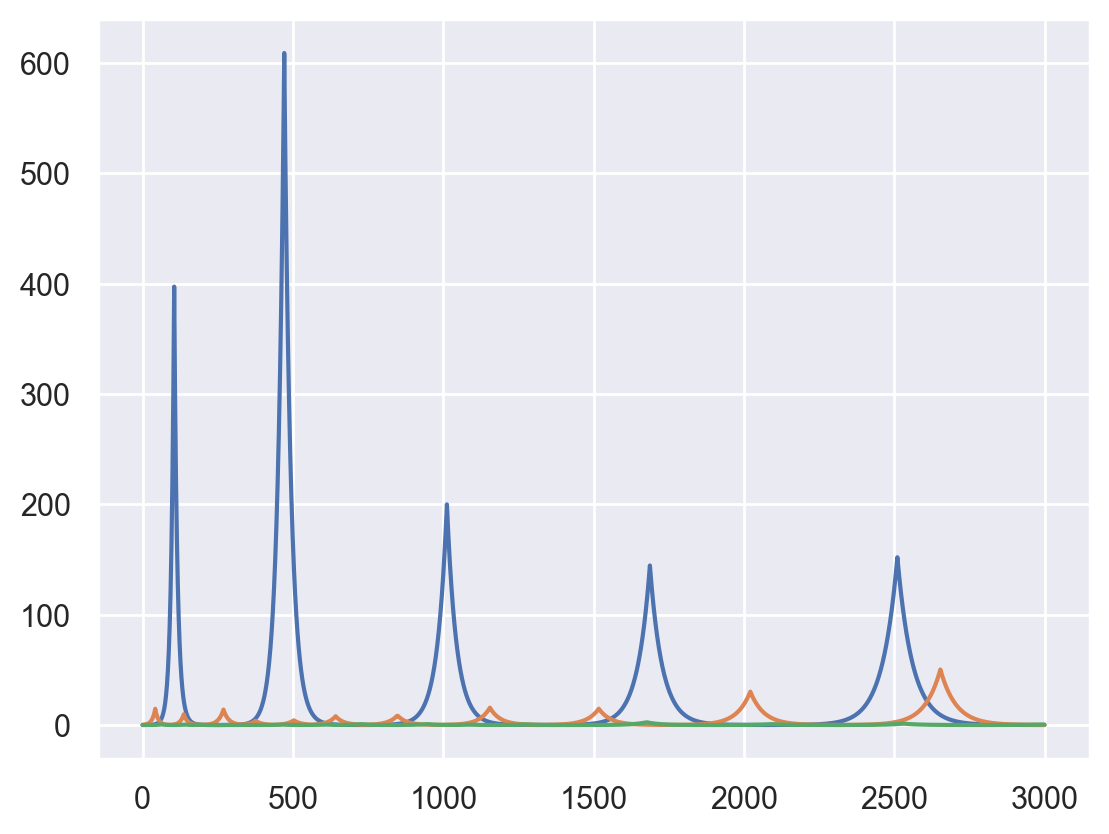

In [76]:
plt.plot(pg_out["adapt_pars"]["rw_sd"]);

In [88]:
def plot_posteriors(pg_out, theta_true=theta, theta_init=theta_init, warmup_frac=5):
    num_warmup = n_iter // warmup_frac

    posteriors = pd.DataFrame(
        pg_out["theta"][num_warmup:], 
        columns = ["theta", "kappa", "mu"])

    plot_posteriors = pd.melt(posteriors, var_name = "param")

    g = sns.FacetGrid(plot_posteriors,
                      sharex=True, sharey=0,
                      col="param", height=4, aspect=1.3, col_wrap=3)
    g.map(plt.plot, "value");

    g = sns.FacetGrid(plot_posteriors,
                      sharex=False, sharey=1,
                      col="param", height=4, aspect=1.3, col_wrap=3)
    g.map(sns.histplot, "value")
    [g.axes[i].axvline(x=theta_true[i], color = "firebrick", ls='-') for i in range(len(theta))];
    [g.axes[i].axvline(x=theta_init[i], color = "green", ls='--') for i in range(len(theta))];
    [g.axes[i].axvline(x=pg_out["theta"][:, i].mean(), color = "black", ls='-') for i in range(len(theta))];

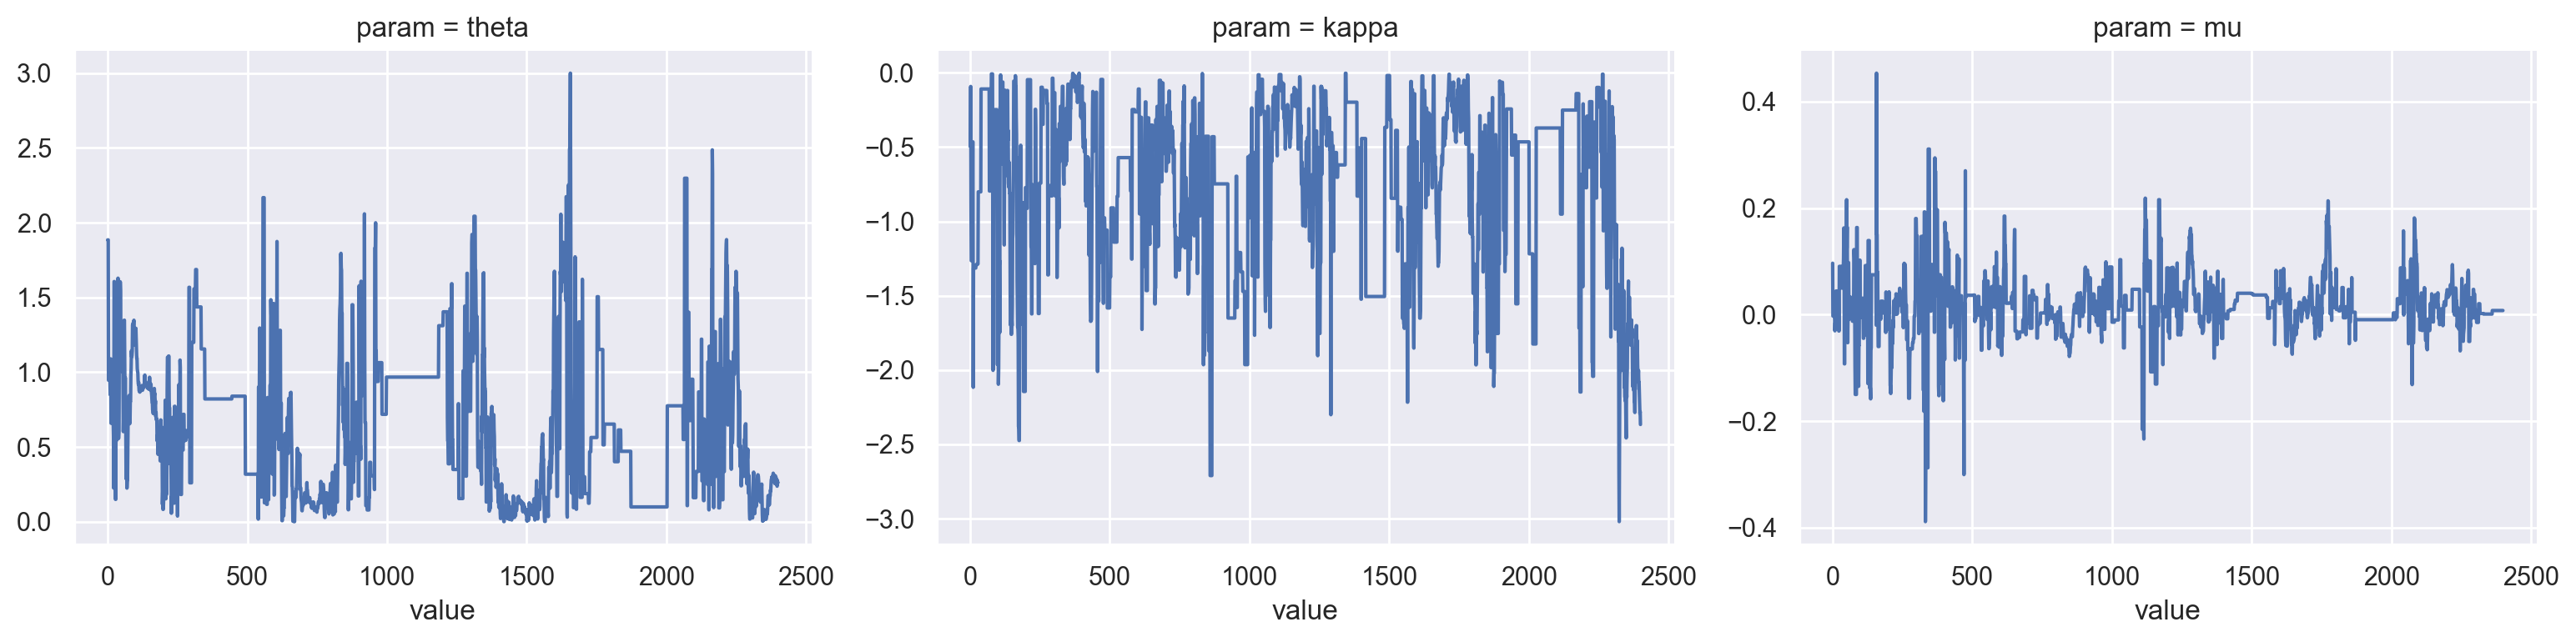

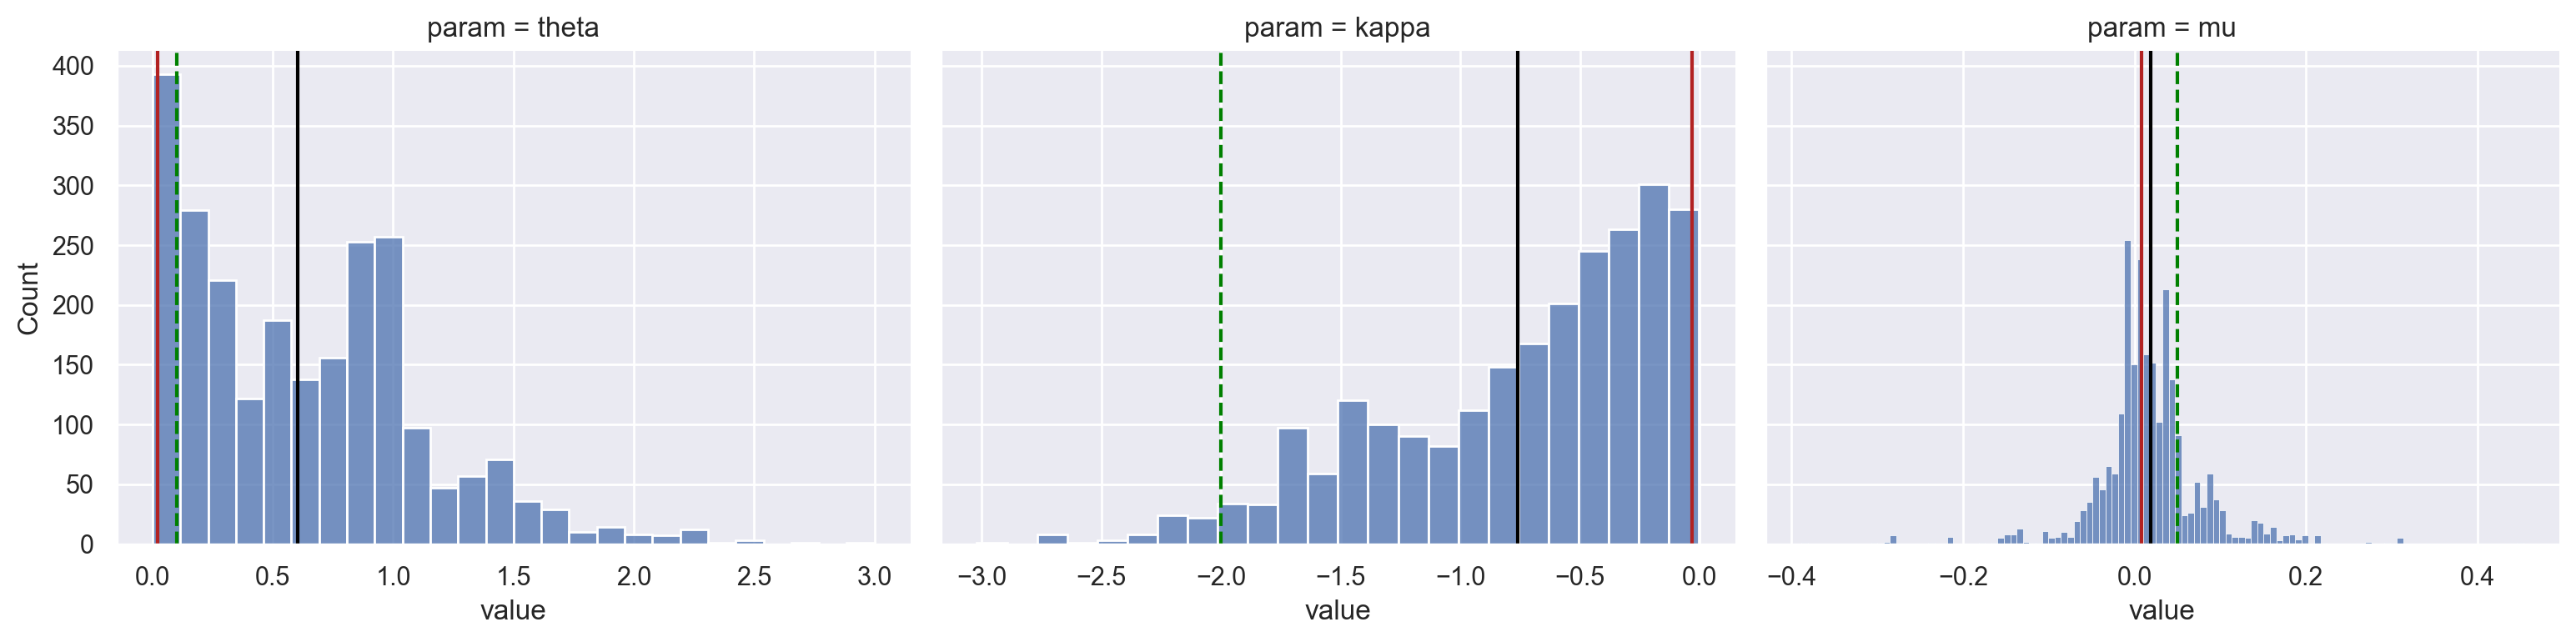

In [89]:
plot_posteriors(pg_out)